У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [65]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import seasonal_decompose

In [66]:
# Завантажуємо дані
df = pd.read_csv('train.csv')

# Перетворюємо колонку 'date' у формат datetime
df['date'] = pd.to_datetime(df['date'])

# Встановлюємо колонку 'date' як індекс датафрейму
df.set_index('date', inplace=True)

# Виводимо перші 10 рядків
print(df.head(10))

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9


In [67]:
# Виводимо інформацію про датафрейм
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



Спробуємо зробити 3 графіки:
1. Лінійний графік середніх продажів одного айтему по всіх магазинах з довірчим інтервалом (наприклад, мінімум і максимум).
2. Кілька ліній (одна на магазин) для одного айтему — щоб порівняти тренди між магазинами.
3. Теплова карта (heatmap) середніх продажів айтемів у різних магазинах (наприклад, середнє за весь період), щоб побачити загальну структуру.

In [68]:
# Зробимо колонку 'store' і 'item' категоріями
df['store'] = df['store'].astype('category')
df['item'] = df['item'].astype('category')

# Візьмемо один айтем, наприклад item = 1
item_id = 1

# Фільтруємо дані для цього айтему
df_item = df[df['item'] == item_id]

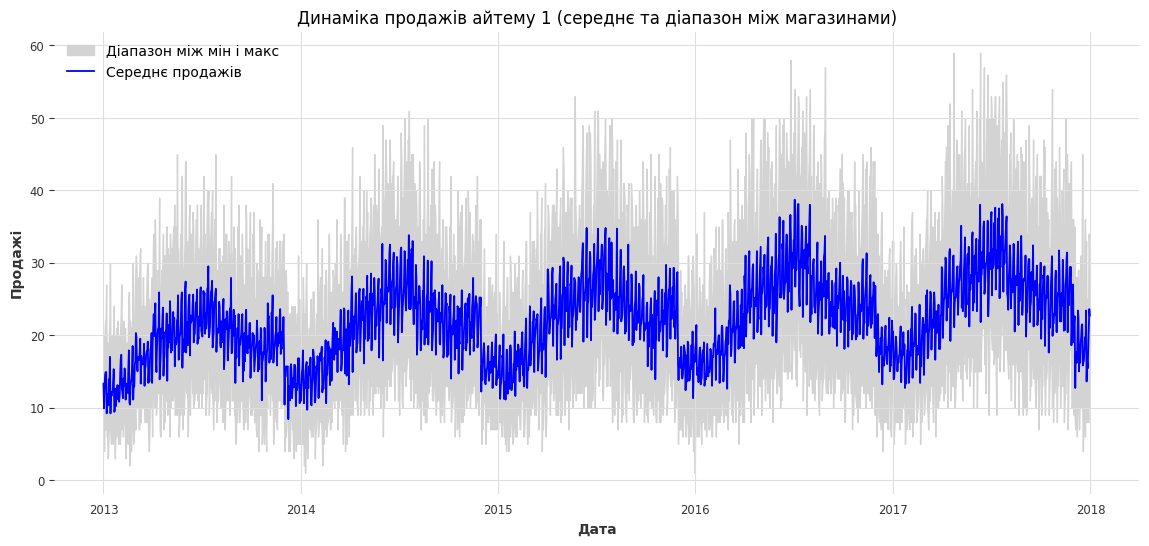

In [69]:
# 1. Середні продажі по датах для цього айтему (усі магазини разом)
mean_sales = df_item.groupby('date')['sales'].mean()
min_sales = df_item.groupby('date')['sales'].min()
max_sales = df_item.groupby('date')['sales'].max()

plt.figure(figsize=(14, 6))
plt.fill_between(mean_sales.index, min_sales, max_sales, color='lightgrey', label='Діапазон між мін і макс')
plt.plot(mean_sales.index, mean_sales, color='blue', label='Середнє продажів')
plt.title(f'Динаміка продажів айтему {item_id} (середнє та діапазон між магазинами)')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.show()

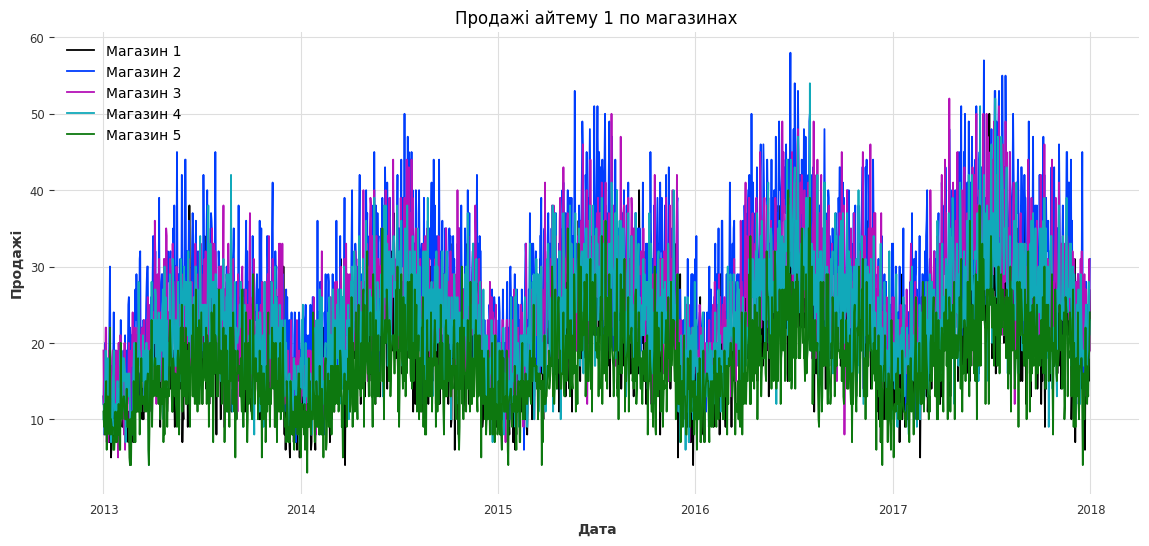

In [70]:
# 2. Лінійний графік продажів по магазинах для того ж айтему (пару магазинів для наочності)
stores_sample = df_item['store'].cat.categories[:5]  # Візьмемо перші 5 магазинів для графіка

plt.figure(figsize=(14, 6))
for store in stores_sample:
    # Reset index to make 'date' a column again, then filter and set index
    sales_store = df_item[df_item['store'] == store].reset_index().set_index('date')['sales']
    sales_store = sales_store.sort_index()
    plt.plot(sales_store.index, sales_store, label=f'Mагазин {store}')

plt.title(f'Продажі айтему {item_id} по магазинах')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.show()

/tmp/ipython-input-3503008086.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_sales_store_item = df.groupby(['store', 'item'])['sales'].mean().unstack()


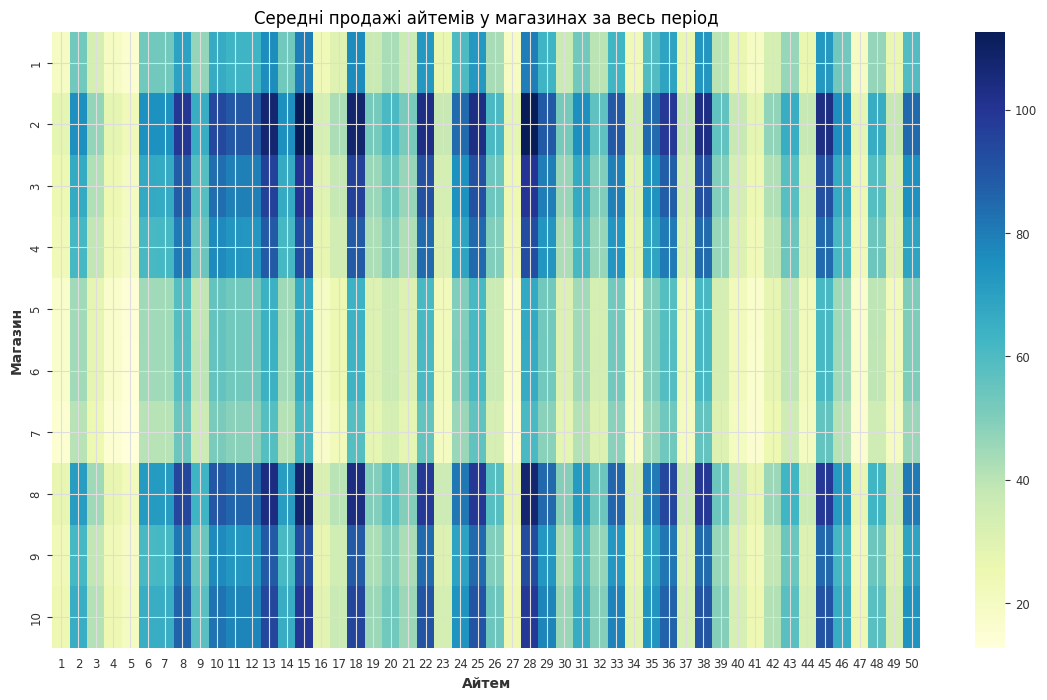

In [71]:
# 3. Теплова карта середніх продажів айтемів по магазинах за весь період
mean_sales_store_item = df.groupby(['store', 'item'])['sales'].mean().unstack()

plt.figure(figsize=(14, 8))
sns.heatmap(mean_sales_store_item, cmap='YlGnBu')
plt.title('Середні продажі айтемів у магазинах за весь період')
plt.xlabel('Айтем')
plt.ylabel('Магазин')
plt.show()

Спостереження:
1. Графік 1 показує, що середня динаміка продажів одного айтему має тенденцію з певними сезонними коливаннями, а діапазон (мінімум і максимум) демонструє, що продажі можуть суттєво відрізнятися між магазинами.
2. Графік 2 підтверджує, що у різних магазинах динаміка продажів одного й того ж товару може суттєво варіюватися, що важливо враховувати при побудові моделей.
3. Теплова карта показує, що середні продажі айтемів відрізняються і за магазинами, і за товарами — деякі магазини продають певні товари краще.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [72]:
# Вибірка для item=1 і store=1
df_sub = df[(df['item'] == 1) & (df['store'] == 1)].sort_index()

# Для декомпозиції потрібно мати рівномірний часовий ряд без пропусків
# Переконаємось, що індекс — це дати, і створимо повний датасет дат
date_range = pd.date_range(start=df_sub.index.min(), end=df_sub.index.max(), freq='D')
df_sub = df_sub.reindex(date_range)

In [73]:
# Заповнимо пропуски, наприклад, лінійною інтерполяцією або нулями
df_sub['sales'] = df_sub['sales'].interpolate().fillna(0)

In [74]:
# Застосуємо адитивну декомпозицію
result = seasonal_decompose(df_sub['sales'], model='additive', period=30)  # period=30, бо місяць ~30 днів

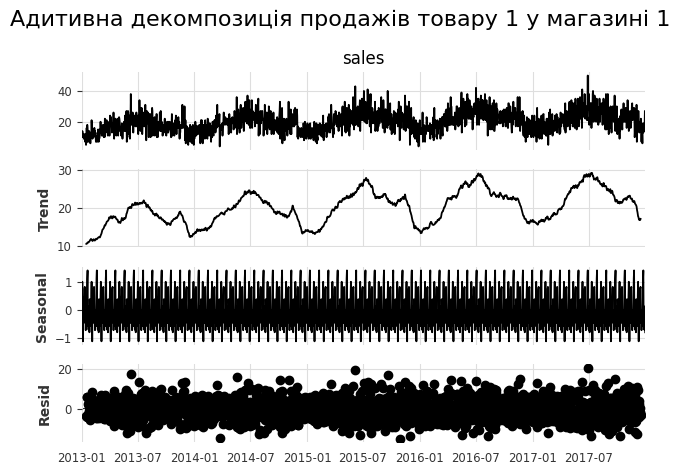

In [75]:
# Побудуємо графіки
fig = result.plot()
plt.suptitle('Адитивна декомпозиція продажів товару 1 у магазині 1', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

Спостереження:
1. Тренд показує загальну тенденцію продажів, наприклад, зростання або спад.
2. Сезонність демонструє регулярні циклічні коливання, наприклад, щомісячні або щотижневі піки.
3. Залишки відображають нерегулярні коливання та шум у даних.

Що могло б допомогти краще зрозуміти:
1. Більш точне визначення періоду сезонності: замість 30 можна спробувати 7 (тиждень), 365 (рік) або провести аналіз автокореляції для пошуку справжніх циклів.
2. Обробка пропусків: інтерполяція чи заповнення нулями може вплинути на результати.
3. Перетворення даних (логарифмічне, Box-Cox) для стабілізації дисперсії.
4. Можливо, варто провести декомпозицію як мультиплікативну модель, якщо сезонність змінюється пропорційно рівню тренду.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [76]:
!pip install darts --quiet

In [77]:
from darts import TimeSeries

# Створюємо TimeSeries тільки з колонки 'sales'
series = TimeSeries.from_series(df_sub['sales'])

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [78]:
# Розбиття на train і validation
train, val = series.split_before(pd.Timestamp("2017-10-01"))

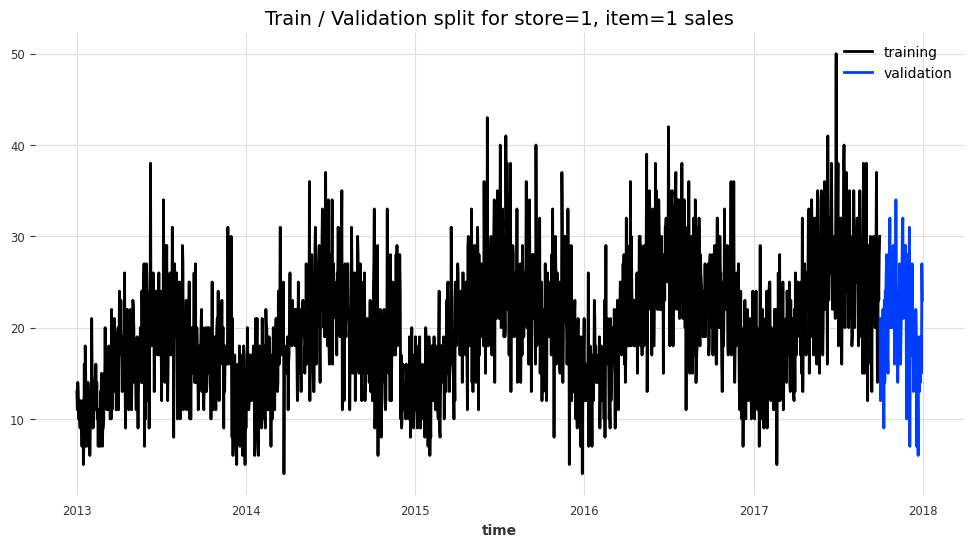

In [79]:
# Побудова графіка
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
train.plot(label="training")
val.plot(label="validation")
plt.title("Train / Validation split for store=1, item=1 sales", fontsize=14)
plt.legend()
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x600 with 0 Axes>

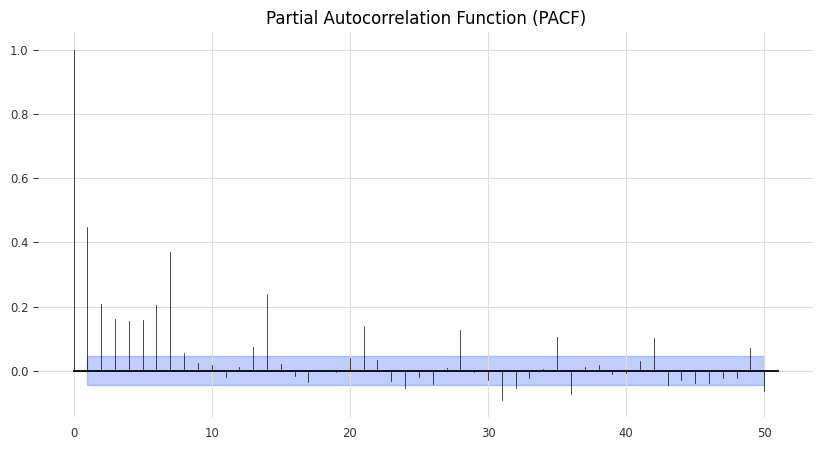

In [80]:
from darts.utils.statistics import plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_pacf(series, max_lag=50)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

Спостереження:

1. Лаг 1 має дуже сильну часткову автокореляцію (майже 1) → це означає, що значення вчорашнього дня дуже сильно впливає на сьогоднішнє.
2. Лаг 2 та лаг 3 також значущі (виходять за сині межі довірчого інтервалу), але їхній вплив помітно менший.
3. Є невеликий значущий стовпчик на лагу 7 → це може бути ознакою тижневої сезонності (особливо для даних щоденних продажів).
4. Інші лаги переважно знаходяться в межах довірчого інтервалу → їх вплив статистично незначущий.
5. Для прогнозування можна розглядати лаги 1, 2, 3 і, можливо, 7 як основні кандидати. Лаг 1 є найважливішим, а лаг 7 може бути ключем до врахування тижневої сезонності.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [81]:
from darts.utils.statistics import check_seasonality

# Тижнева сезонність
is_seasonal, period = check_seasonality(train, m=7, max_lag=50)
print(f"Сезонність m=7: {is_seasonal}, період: {period}")

# Місячна сезонність
is_seasonal, period = check_seasonality(train, m=30, max_lag=50)
print(f"Сезонність m=30: {is_seasonal}, період: {period}")

# Річна сезонність
is_seasonal, period = check_seasonality(train, m=365, max_lag=400)
print(f"Сезонність m=365: {is_seasonal}, період: {period}")

Сезонність m=7: True, період: 7
Сезонність m=30: False, період: 30
Сезонність m=365: False, період: 365


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

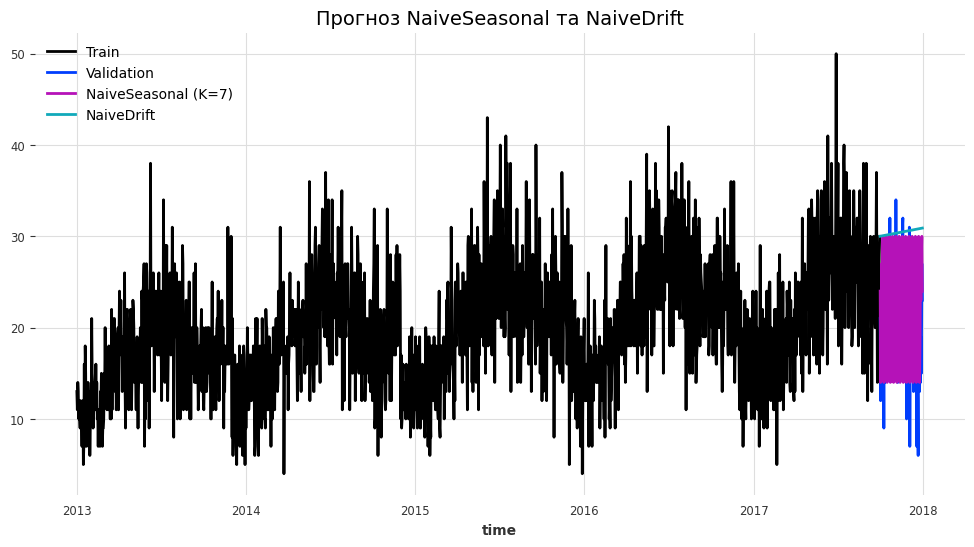

In [82]:
from darts.models import NaiveSeasonal, NaiveDrift
import matplotlib.pyplot as plt

# Кількість кроків прогнозування = довжина валідаційного періоду
forecast_horizon = len(val)

# NaiveSeasonal
seasonal_model = NaiveSeasonal(K=7)  # K = період сезонності
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(forecast_horizon)

# NaiveDrift
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(forecast_horizon)

# Візуалізація
plt.figure(figsize=(12, 6))
train.plot(label="Train")
val.plot(label="Validation")
seasonal_forecast.plot(label="NaiveSeasonal (K=7)")
drift_forecast.plot(label="NaiveDrift")
plt.title("Прогноз NaiveSeasonal та NaiveDrift", fontsize=14)
plt.legend()
plt.show()

Спостереження:

1. NaiveSeasonal добре працює, якщо дані мають стабільну і регулярну сезонність,наприклад, щотижневі патерни. Це те, що ми тут маємо якраз.
2. NaiveDrift підходить, якщо дані мають чіткий тренд, але не обов’язково сезонність.
3. Проте обидві моделі — прості бенчмарки, і вони не враховують складних взаємозв’язків, тож точність може бути обмежена.

Як покращити наївні моделі:
1. Використати комбінований прогноз (середнє NaiveSeasonal + NaiveDrift).
2. Налаштувати параметр K в NaiveSeasonal на інший період (наприклад, 14, якщо є 2-тижневий патерн).
3. Запустити NaiveSeasonal на попередньо згладжених даних (наприклад, moving average).

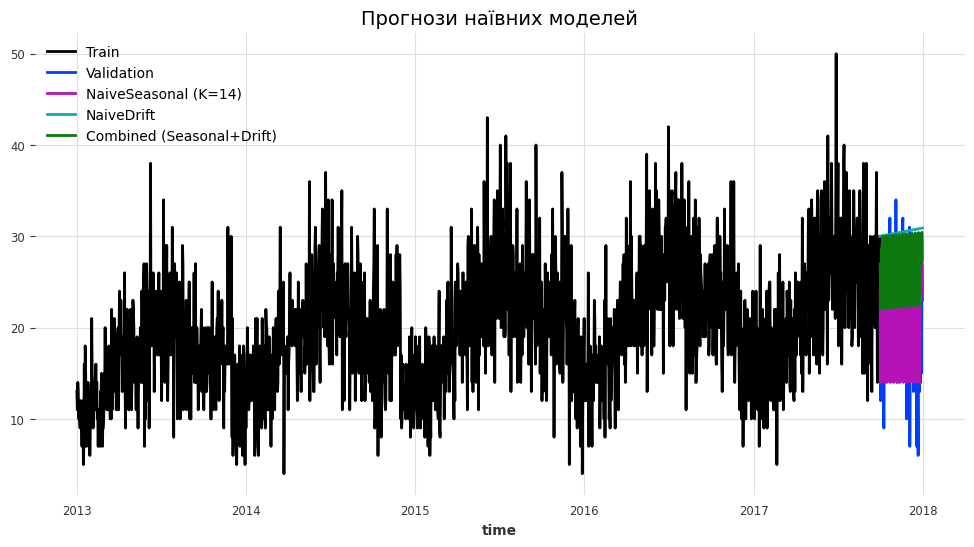

In [83]:
from darts.models import NaiveSeasonal, NaiveDrift
import matplotlib.pyplot as plt
import numpy as np

# Кількість кроків прогнозування
forecast_horizon = len(val)

# NaiveSeasonal
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
forecast_seasonal = seasonal_model.predict(forecast_horizon)

# NaiveDrift
drift_model = NaiveDrift()
drift_model.fit(train)
forecast_drift = drift_model.predict(forecast_horizon)

# Комбінація (середнє прогнозів)
forecast_combined = forecast_seasonal + (forecast_drift - forecast_seasonal) * 0.5
# або: forecast_combined = (forecast_seasonal + forecast_drift) / 2

# Візуалізація
plt.figure(figsize=(12, 6))
train.plot(label="Train")
val.plot(label="Validation")
forecast_seasonal.plot(label="NaiveSeasonal (K=14)")
forecast_drift.plot(label="NaiveDrift")
forecast_combined.plot(label="Combined (Seasonal+Drift)")
plt.title("Прогнози наївних моделей", fontsize=14)
plt.legend()
plt.show()

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [84]:
from darts.metrics import mape

mape_seasonal = mape(val, forecast_seasonal)
mape_drift = mape(val, forecast_drift)
mape_combined = mape(val, forecast_combined)

print(f"MAPE NaiveSeasonal: {mape_seasonal:.2f}%")
print(f"MAPE NaiveDrift: {mape_drift:.2f}%")
print(f"MAPE Combined: {mape_combined:.2f}%")

MAPE NaiveSeasonal: 38.17%
MAPE NaiveDrift: 68.74%
MAPE Combined: 49.11%


Спостереження: наївні моделі можуть бути корисними як базовий бенчмарк, але тут перевага явно за NaiveSeasonal з періодом, що відповідає виявленій сезонності.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [85]:
# Встановимо необхідні пакети
!pip install darts xgboost --quiet

import pandas as pd
from darts import TimeSeries
from darts.models import XGBModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import matplotlib.pyplot as plt

MAPE: 27.98343766258595
RMSE: 5.226553077796954


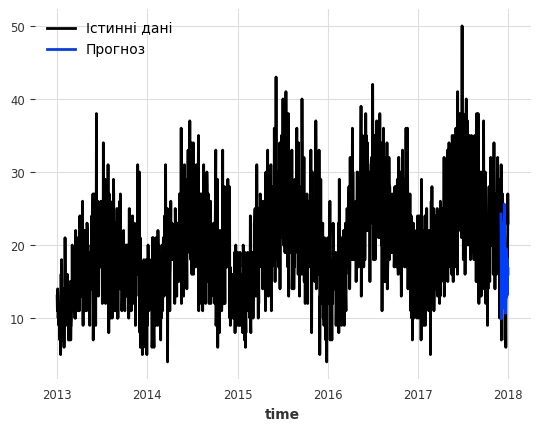

In [86]:
# Додаткові ознаки з дати
month = datetime_attribute_timeseries(series, attribute='month', cyclic=True)
day_of_week = datetime_attribute_timeseries(series, attribute='day_of_week', cyclic=True)
day_of_month = datetime_attribute_timeseries(series, attribute='day', cyclic=True)
quarter = datetime_attribute_timeseries(series, attribute='quarter', cyclic=True)

covariates = month.stack(day_of_week).stack(day_of_month).stack(quarter)

# Розділимо на тренувальний та тестовий набори
train, test = series[:-30], series[-30:]
train_cov, test_cov = covariates[:-30], covariates[-30:]

# Створимо і натренуємо XGBModel
model = XGBModel(lags=30, lags_future_covariates=[0], output_chunk_length=1)
model.fit(train, future_covariates=train_cov)

# Прогноз
forecast = model.predict(n=30, future_covariates=test_cov)

# Оцінка якості
print("MAPE:", mape(test, forecast))
print("RMSE:", rmse(test, forecast))

# Візуалізація
series.plot(label='Істинні дані')
forecast.plot(label='Прогноз')
plt.legend()
plt.show()

Спостереження: модель XGBModel змогла захопити загальний тренд даних, але точність прогнозу поки обмежена: MAPE ≈ 28% і RMSE ≈ 5.2 свідчать про помірну відхилення прогнозу від реальних значень. Ймовірно, модель потребує більше історичних лагів, додаткових ознак (свята, вихідні) або трансформації ряду для покращення прогнозу. Загалом, результат прийнятний для початкової моделі, але є потенціал для значного поліпшення.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [87]:
# Встановимо darts, якщо ще не встановлено
!pip install darts --quiet

import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import mape, rmse
import matplotlib.pyplot as plt

MAPE: 48.49106069777558
RMSE: 6.89652546990837


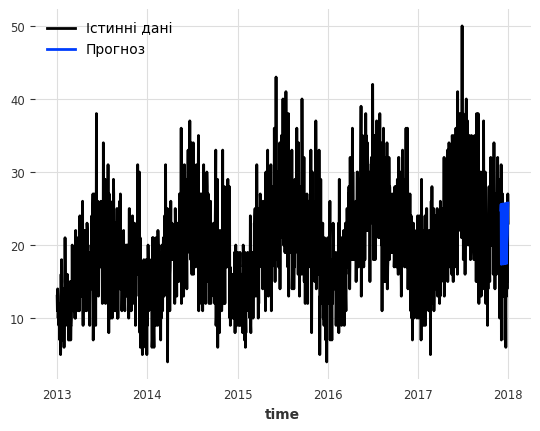

In [88]:
# Розділимо на тренувальний і тестовий набори
train, test = series[:-30], series[-30:]

# Створимо і натренуємо модель
model = ExponentialSmoothing()
model.fit(train)

# Прогноз
forecast = model.predict(n=30)

# Оцінка якості
print("MAPE:", mape(test, forecast))
print("RMSE:", rmse(test, forecast))

# Візуалізація
series.plot(label='Істинні дані')
forecast.plot(label='Прогноз')
plt.legend()
plt.show()

Спостереження: модель ExponentialSmoothing відображає загальний тренд, але не здатна врахувати складні сезонні коливання чи різкі зміни в ряді. Для покращення прогнозу варто розглянути моделі з більшою гнучкістю, наприклад XGBModel або Prophet, або додати зовнішні ознаки.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

MAPE: 34.2486813466593
RMSE: 5.7450223462537515


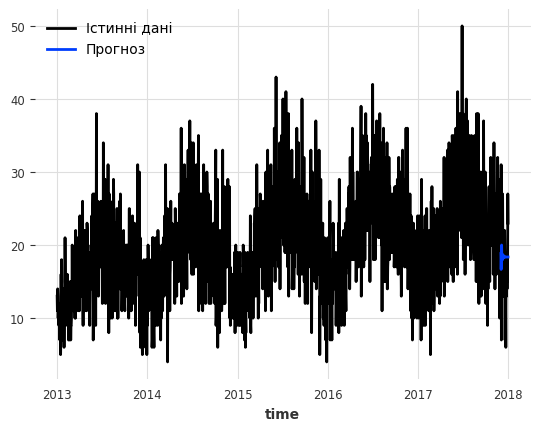

In [89]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape, rmse
import matplotlib.pyplot as plt

# Розділимо на тренувальний і тестовий набори
train, test = series[:-30], series[-30:]

# Створимо і натренуємо ARIMA
# Параметри p,d,q можна підібрати приблизно, наприклад p=5, d=1, q=0
model = ARIMA(p=5, d=1, q=0)
model.fit(train)

# Прогноз
forecast = model.predict(n=30)

# Оцінка якості
print("MAPE:", mape(test, forecast))
print("RMSE:", rmse(test, forecast))

# Візуалізація
series.plot(label='Істинні дані')
forecast.plot(label='Прогноз')
plt.legend()
plt.show()

Спостереження: ARIMA краще відображає тренди і деякі коливання в даних, але не справляється зі складними сезонними паттернами чи різкими стрибками. Модель придатна для базового прогнозування, але для підвищення точності варто спробувати більш гнучкі моделі (XGBModel, Prophet або інші моделі з зовнішніми ознаками).

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

MAPE: 46.36110124950708
RMSE: 6.68145106034829


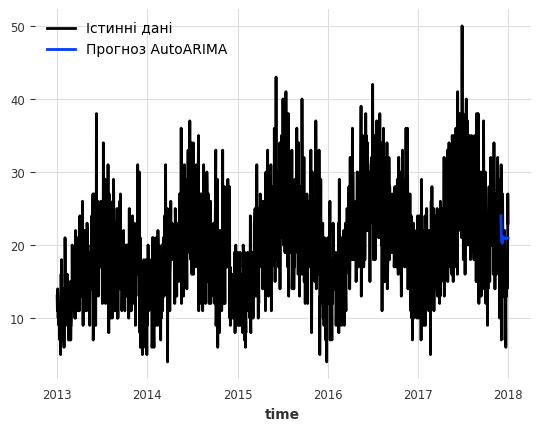

In [90]:
from darts.models import AutoARIMA
from darts.metrics import mape, rmse
import matplotlib.pyplot as plt

# Навчання AutoARIMA
auto_model = AutoARIMA()
auto_model.fit(train)

# Прогноз
forecast = auto_model.predict(n=30)

# Оцінка якості
print("MAPE:", mape(test, forecast))
print("RMSE:", rmse(test, forecast))

# Візуалізація
series.plot(label='Істинні дані')
forecast.plot(label='Прогноз AutoARIMA')
plt.legend()
plt.show()

Можу сказати, що автоматичне підбирання параметрів ARIMA не покращило точність прогнозу порівняно з ручною ARIMA (MAPE ≈ 34.2%, RMSE ≈ 5.75). Це показує, що мій часовий ряд має складні коливання або різкі стрибки, які стандартна ARIMA не може добре моделювати. Для більш точного прогнозу я планую використовувати XGBModel або моделі з додатковими ознаками.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1315rfqk/jtm5id09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1315rfqk/fcper34u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87946', 'data', 'file=/tmp/tmp1315rfqk/jtm5id09.json', 'init=/tmp/tmp1315rfqk/fcper34u.json', 'output', 'file=/tmp/tmp1315rfqk/prophet_modelr61c_gne/prophet_model-20250815181648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 27.903817707739645
RMSE: 4.6550991983762335


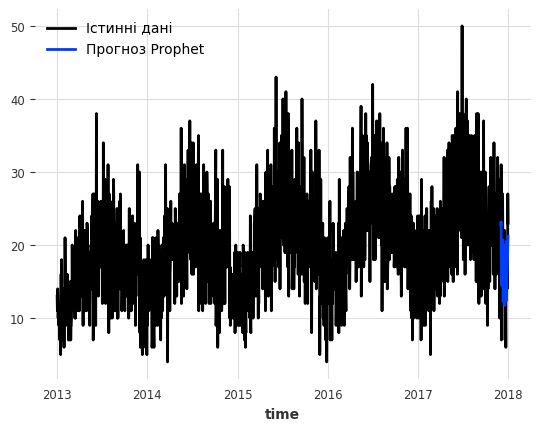

In [91]:
# Розділимо на тренувальний і тестовий набори
train, test = series[:-30], series[-30:]

# Створимо і натренуємо модель Prophet
model = Prophet()
model.fit(train)

# Прогноз
forecast = model.predict(n=30)

# Оцінка якості
print("MAPE:", mape(test, forecast))
print("RMSE:", rmse(test, forecast))

# Візуалізація
series.plot(label='Істинні дані')
forecast.plot(label='Прогноз Prophet')
plt.legend()
plt.show()

Можу сказати, що Prophet показала найкращу точність серед усіх моделей, які я тестувала раніше. Вона добре відображає тренди та сезонні коливання в даних. Прогноз набагато точніший, ніж у ExponentialSmoothing, ARIMA та AutoARIMA, тому для цього ряду Prophet виглядає найбільш придатною моделлю.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.064     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 50.76841398694674
RMSE: 7.343728427294135


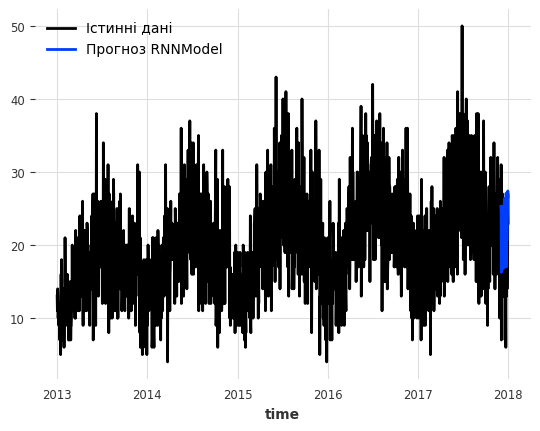

In [92]:
from darts.models import RNNModel
import torch
from darts.metrics import mape, rmse
import matplotlib.pyplot as plt

# Створюємо модель LSTM
model = RNNModel(
    model='LSTM',                 # тип RNN: LSTM або GRU
    input_chunk_length=12,        # довжина вхідного фрагмента
    n_rnn_layers=2,
    hidden_dim=25,                # кількість нейронів у прихованому шарі
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42,
    pl_trainer_kwargs={"accelerator": "gpu" if torch.cuda.is_available() else "cpu"}
)

# Навчання моделі
model.fit(train, verbose=True)

# Прогноз на 30 кроків вперед
forecast = model.predict(n=30)

# Оцінка якості
print("MAPE:", mape(test, forecast))
print("RMSE:", rmse(test, forecast))

# Візуалізація
series.plot(label='Істинні дані')
forecast.plot(label='Прогноз RNNModel')
plt.legend()
plt.show()


Я натренувала модель RNNModel для прогнозу нашого часового ряду. Модель показала MAPE ≈ 50.77 та RMSE ≈ 7.34, що значно гірше, ніж у моделей Prophet або XGBoost. Це показує, що RNN на наших даних не змогла добре навчитися через невеликий обсяг ряду та швидку змінність продажів. Модель відтворює загальні тренди, але робить великі помилки у прогнозі.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1315rfqk/uarwqvhl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1315rfqk/7cjwkiij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10376', 'data', 'file=/tmp/tmp1315rfqk/uarwqvhl.json', 'init=/tmp/tmp1315rfqk/7cjwkiij.json', 'output', 'file=/tmp/tmp1315rfqk/prophet_modelr_m7249c/prophet_model-20250815182212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   8%|▊         | 1/12 [00:00<00:04,  2.56it/s]INFO:prophet:D

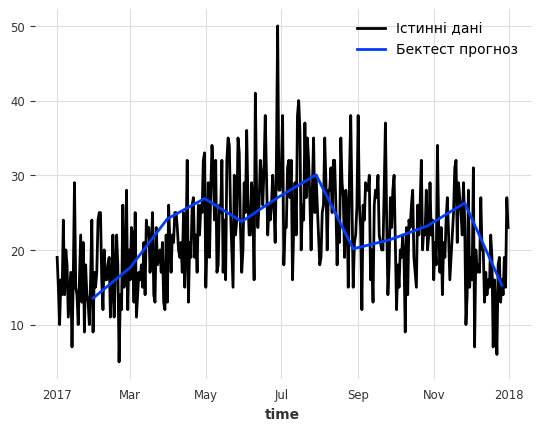

MAPE бектесту: 24.490479568804393
RMSE бектесту: 5.0555596038884785


In [93]:
from darts.models import Prophet
from darts.metrics import mape, rmse
import matplotlib.pyplot as plt
import pandas as pd

# Припустимо, найкраща модель - Prophet
best_model = Prophet()
# best_model.fit(series) # Модель буде перенавчатися в historical_forecasts з retrain=True

# Виконуємо бектест на останні 12 місяців
forecast_horizon = 30  # прогноз на 1 місяць
backtest_series = series[-365:]  # останній рік для бектесту

historical_forecasts = best_model.historical_forecasts(
    series,
    start=pd.Timestamp(series.time_index[-365]),  # початок бектесту
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,   # крок прогнозу = 1 місяць
    retrain=True,             # повторне навчання перед кожним прогнозом (обов'язково для Prophet)
    verbose=True
)

# Візуалізація
series[-365:].plot(label='Істинні дані')
historical_forecasts.plot(label='Бектест прогноз')
plt.legend()
plt.show()

# Оцінка точності бектесту
mape_value = mape(backtest_series, historical_forecasts)
rmse_value = rmse(backtest_series, historical_forecasts)
print("MAPE бектесту:", mape_value)
print("RMSE бектесту:", rmse_value)

Модель показала MAPE ≈ 24.49 та RMSE ≈ 5.06, що свідчить про досить високу точність. Прогнози добре повторюють сезонні тренди та загальні коливання продажів, і модель поводилась стабільно протягом усього року.

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Я б підходила так: у нас є 50 товарів у 10 магазинах, тобто 500 часових рядів. Для кожного “товар–магазин” я б тренувала окрему модель, бо продажі можуть сильно відрізнятися між магазинами.
Я б спробувала Prophet або AutoARIMA, бо вони легко навчаються, враховують сезонність і свята, і дають непоганий прогноз навіть на невеликих даних.
Усього я б тренувала 500 моделей — по одній на кожен ряд. Це дозволяє моделі добре підлаштуватися під особливості продажів кожного товару в кожному магазині. Якщо б хотіла враховувати ще багато зовнішніх факторів, можна було б спробувати RNN або XGBoost.

In [94]:
from IPython.display import clear_output
clear_output(wait=True)

In [95]:
# Очистка всіх віджетів і збереження notebook
import os

# Заміни на ім'я свого notebook
notebook_filename = "HW 2.5 Time Series Analysis.ipynb"

# Виконати очистку виджетів через nbconvert
os.system(f"jupyter nbconvert --ClearWidgetsPreprocessor.enabled=True --inplace {notebook_filename}")

print(f"Notebook {notebook_filename} очищено від віджетів і готовий до завантаження на GitHub.")

Notebook HW 2.5 Time Series Analysis.ipynb очищено від віджетів і готовий до завантаження на GitHub.


In [96]:
!jupyter nbconvert --ClearWidgetsPreprocessor.enabled=True --inplace "HW 2.5 Time Series Analysis.ipynb"


[NbConvertApp] WARNING | pattern 'HW 2.5 Time Series Analysis.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=Tru